In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import numpy as np
from gensim.models import KeyedVectors
from sklearn.cross_decomposition import CCA
import seaborn as sns

/kaggle/input/question-pairs-dataset/questions.csv
/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin


In [2]:
df=pd.read_csv("../input/question-pairs-dataset/questions.csv")
print("number of data points",df.shape[0])

number of data points 404351


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404351 entries, 0 to 404350
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404351 non-null  int64 
 1   qid1          404351 non-null  int64 
 2   qid2          404351 non-null  int64 
 3   question1     404350 non-null  object
 4   question2     404349 non-null  object
 5   is_duplicate  404351 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [4]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [5]:
df=df.dropna()
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [6]:
nan_rows=df[df.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<AxesSubplot:xlabel='is_duplicate'>

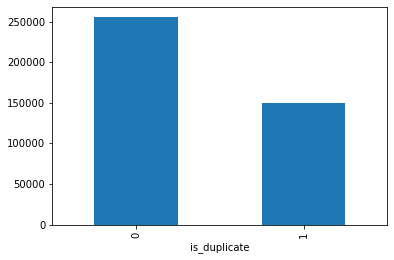

In [7]:
df.groupby('is_duplicate')['id'].count().plot.bar()

In [8]:
print("question pairs that are not similar {}".format(100-round(df['is_duplicate']).mean()*100,2))
print("question pairs that are similar {}".format(round(df['is_duplicate']).mean()*100))

question pairs that are not similar 63.07487609682749
question pairs that are similar 36.92512390317251


In [9]:
vecfile = "../input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin"
vecs = KeyedVectors.load_word2vec_format(vecfile, binary =True)
vecs.init_sims(replace=True)

In [10]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
pip install inflect

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [12]:
import inflect
import re
from nltk.corpus import stopwords
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.stats.mstats import spearmanr as spr

In [13]:
def remove_punctuation(words):
    #new_words = []
    #for word in wordings:
    new_word = re.sub(r'[^\w\s]', "", words)

    return new_word

def replace_numbers(words):
    p = inflect.engine()
    new_word = words.split()
    new_words=[]
    for word in new_word:
        if word.isdigit():
            new = p.number_to_words(word)
            new_words.append(new)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    words= [w for w in words if not w in stopwords.words('english')]
    return words

In [14]:
def normalize(words):
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words= remove_stopwords(words)
    return words

In [15]:
print(df['question1'][0])
print(df['question2'][0])

What is the step by step guide to invest in share market in india?
What is the step by step guide to invest in share market?


In [16]:
normalize(df['question1'][0])

['What', 'step', 'step', 'guide', 'invest', 'share', 'market', 'india']

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [18]:
qw = " ".join(review for review in df.question1)
print ("There are {} words in the combination of all review.".format(len(qw)))
qe = " ".join(review for review in df.question2)
print ("There are {} words in the combination of all review.".format(len(qe)))

There are 24476755 words in the combination of all review.
There are 24706885 words in the combination of all review.


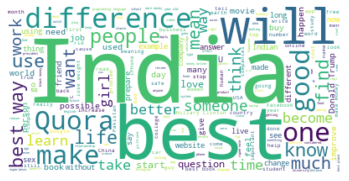

In [19]:
wordcloud = WordCloud(background_color="white").generate(qw)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

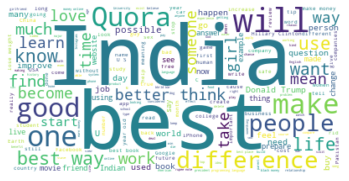

In [20]:
wordcloud = WordCloud(background_color="white").generate(qe)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [21]:
def compute_cosine_similarity(vector1, vector2):
    cos=vector1.dot(vector2)/(np.linalg.norm(vector1, ord=2) * np.linalg.norm(vector2, ord=2))
    if np.isnan(cos):
        return 0.500
    else:
        return cos

In [22]:
def cca_sem(df, vecs):
    #write_str  = []
    sims = []
    sim = 0
    original_value=[]
    for i in range(500):
        sent1 = df['question1'][i]
        sent2 = df['question2'][i]
        
        original_value.append(df['is_duplicate'][i])
        words_in_sent1 = normalize(sent1)
        words_in_sent2 = normalize(sent2)
        stems1 = []
        for word in words_in_sent1:
            if word in vecs:
                stems1.append(word)
        stems2 = []
        for word in words_in_sent2:
            if word in vecs:
                stems2.append(word)

    
        len_1 = len(stems1)
        len_2 = len(stems2)
        len_min = min(len_1, len_2,8)

        
        sim=[]
        if len_min == 1:
            sims.append(0.500)
    
        v1 = np.asarray(vecs["hi"])
        for word in stems1:
            x = np.asarray(vecs[word])
            v1 = np.vstack((v1, x))

        v2 = np.asarray(vecs["hi"])
        for word in stems2:
            x = np.asarray(vecs[word])
            v2 = np.vstack((v2, x))
    
        v1 = np.delete(v1, 0, 0)
        v2 = np.delete(v2, 0, 0)
        b = len_min
        cca = CCA(n_components=b,max_iter=15000)
        cca.fit(v1.T,v2.T)
        X_c, Y_c = cca.transform(v1.T, v2.T)        
        sim =0

        X_T = X_c.T
        Y_T = Y_c.T
        for i in range(b):
            v1 = []
            v1 = X_T[i]
            w11 = np.asarray(v1)
            v2 = []
            v2 = Y_T[i]
            w21 = np.asarray(v2)
            sim_1 = compute_cosine_similarity(v1, v2)
            sim =sim + sim_1
            
        sim = sim/b
        sims.append(sim)
       

    print(sims)
    count=0
    arrr=[]
    for i in range(len(sims)):
        if sims[i]>0.7 or sims[i]<0.001:
            arrr.append(1)
        else:
            arrr.append(0)
    for i in range(len(sims)):
        if df['is_duplicate'][i]==arrr[i]:
            count+=1
    print(arrr)
    #print(count)
    ann=count/500
    print(ann*100,"% results matched")
    #sims_scaled = [(i - s_min)/(s_max - s_min) for i in sims]
    #for i in range(0,len(write_str)):
        #output.write(write_str[i] + str(sims_scaled[i]))
      #  sims_scaled[i]   =  float(sims_scaled[i])
     #   original_value[i] = float(original_value[i])
    #covariance = pearsonr(sims_scaled,original_value)
    #print(covariance)

In [23]:
df=pd.read_csv("../input/question-pairs-dataset/questions.csv")
cca_sem(df,vecs)

/opt/conda/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:77: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:77: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:77: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:77: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:77: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:77: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/cross

[0.14263866758921975, 0.8651267873468892, 0.6901467438297025, 0.14191125938734658, 0.6164031218523074, -4.597717241529298e-05, -0.17423221363068278, 0.9169620506372573, 0.9999999939419363, 0.5805390066873982, 0.0953104343063792, 0.4434029709920299, 1.8169030293213594e-05, 0.7754192299076701, -0.11123437746254514, 0.00012136980460294723, 0.8760864138766301, 0.11699110140057892, 0.4999729946535323, 0.5999999999995891, 0.7501031928158775, -0.05247585670915497, 0.7500845123904434, 0.3515929424345452, 0.20110325283876324, 0.1499816385651369, 0.9990636173914921, -0.018657788605709102, 0.24457580989409677, 0.19246535325789704, 0.1674675702405577, 0.1463317269682077, 0.4322773228355298, 0.04156266120587933, 0.9851492868406496, -0.04898214181271274, 0.49999364832823123, -0.37494070772869303, 0.7246954955197545, 0.15076011707787715, 0.37514077200270446, 0.33333331274004235, 0.0019887188584426507, 0.44111107484247525, 0.4999999878430226, 0.20001930882507302, 0.1042489625063064, 0.2496629988792787

/opt/conda/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:77: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
